In [1]:
from datasets import load_dataset
import tensorflow as tf
import numpy as np
from tokenizers import Tokenizer
from tokenizers import normalizers
from tokenizers.models import BPE
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import NFD, StripAccents
from sklearn.model_selection import train_test_split
import os

In [2]:
from tensorflow.keras.layers import Embedding, Input, Dropout, Dense, Activation, Reshape, LayerNormalization, Concatenate, Add
from tensorflow.keras.models import Model

In [3]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
def get_all_sentences(ds):
    for i in range(len(ds)):
        yield ds[i]

In [5]:
def build_or_get_tokenizer(ds,path):

    tokenizer_path=path

    if not os.path.exists(path):
        tokenizer=Tokenizer(WordLevel(unk_token='[UNK]'))
        tokenizer.pre_tokenizer=Whitespace()
        trainer = WordLevelTrainer(special_tokens=["[UNK]","[PAD]","[SOS]","[EOS]"])
        tokenizer.train_from_iterator(get_all_sentences(ds),trainer=trainer)
        tokenizer.save(tokenizer_path)
    else:
        tokenizer=Tokenizer.from_file(tokenizer_path)

    return tokenizer

In [6]:
def get_tokenizer(ds,path):
    tokenizer_path=path
    
    if not os.path.exists(path):
        tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
        normalizer=normalizers.Sequence([NFD(), StripAccents()])
        tokenizer.normalizer = normalizer
        tokenizer.pre_tokenizer=Whitespace()
        trainer = BpeTrainer(special_tokens=["[UNK]","[PAD]","[SOS]","[EOS]"],vocab_size=30000)
        tokenizer.train_from_iterator(get_all_sentences(ds),trainer=trainer)
        tokenizer.save(tokenizer_path)
    else:
        tokenizer=Tokenizer.from_file(tokenizer_path)

    return tokenizer
    

In [7]:
def filter_data(tokenizer,input,output,input_size,output_size):

    # Create input and output lists
    input_list=[]
    output_list=[]
    # Filter through the data and choose suitable examples
    for i in range(len(input)):
        in_tokenized = tokenizer.encode("[SOS] "+input[i]+" [EOS]").ids
        out_tokenized = tokenizer.encode("[SOS]"+output[i]+" [EOS]").ids
        if len(in_tokenized)<=input_size and len(out_tokenized)<=output_size:
            input_list.append(in_tokenized)
            output_list.append(out_tokenized)
    
    return input_list,output_list

In [8]:
def padding_mapper(x,y,sos,input_size,output_size):

    # Create encoder input
    padding_length=input_size-len(x)
    padding_length=max(0,padding_length)
    encoder_input = tf.pad(x,np.array([[0,padding_length]]),constant_values=1)

    # Create encoder mask
    encoder_mask = np.arange(input_size)
    encoder_mask = encoder_mask<len(x)
    encoder_mask = encoder_mask.astype(int)
    encoder_mask = encoder_mask.reshape(1,1,input_size)

    # Create decoder input
    padding_length=output_size-len(sos)
    padding_length=max(0,padding_length)
    decoder_input = tf.pad(sos,np.array([[0,padding_length]]),constant_values=1)
    
    # identify padding length for y
    padding_length=output_size-len(y)
    padding_length=max(0,padding_length)
    decoder_output = tf.pad(y,np.array([[0,padding_length]]),constant_values=1)

    # Create Decoder mask
    decoder_mask = np.arange(output_size)
    decoder_mask = decoder_mask<len(sos)
    decoder_mask = decoder_mask.astype(int)
    decoder_mask = decoder_mask.reshape(1,1,output_size)

    return ((encoder_input,encoder_mask,decoder_input,decoder_mask),decoder_output)

In [9]:
def get_ds(data_path,tokenizer_path,input_size,output_size,split='train',key='INSTRUCTION',value='RESPONSE',get_tokenization=get_tokenizer):
    ds_raw=load_dataset(data_path)
    input=ds_raw[split][key]
    output=ds_raw[split][value]
    tokenizer_data=[input+output]

    # Build Tokenizer
    tokenizer = get_tokenization(tokenizer_data,tokenizer_path)

    # Filter Data
    input, output = filter_data(tokenizer,input, output,input_size,output_size)

    return input,output,tokenizer,len(input)

In [10]:
def data_loader(input,output,input_size,output_size,index=0):
    while(True):
        batch_size=0
        for i in range(index,len(input)):
            for j in range(0,300):
                if batch_size==0:
                    encoder_input_list=[]
                    encoder_mask_list=[]
                    decoder_input_list=[]
                    decoder_mask_list=[]
                    decoder_output_list=[]
                if j>len(output[i]):
                    break 
                temp=padding_mapper(input[i],output[i][:j+1],output[i][:j],input_size,output_size)
                ((encoder_input,encoder_mask,decoder_input,decoder_mask),decoder_output)=temp
                encoder_input_list.append(np.array(encoder_input))
                encoder_mask_list.append(np.array(encoder_mask))
                decoder_input_list.append(np.array(decoder_input))
                decoder_mask_list.append(np.array(decoder_mask))
                decoder_output_list.append(np.array(decoder_output))
                batch_size+=1
                if batch_size>=10:
                    batch_size=0
                    encoder_input_list=np.array(encoder_input_list)
                    encoder_mask_list=np.array(encoder_mask_list)
                    decoder_input_list=np.array(decoder_input_list)
                    decoder_mask_list=np.array(decoder_mask_list)
                    decoder_output_list=np.array(decoder_output_list)
                    yield ((encoder_input_list,encoder_mask_list,decoder_input_list,decoder_mask_list),decoder_output_list)

In [11]:
class Transformer():
    def __init__(self,
            input_sequence_length=50,
            output_sequence_length=100,
            d_model=256,
            src_vocab_size=30000,
            trg_vocab_size=30000,
            n_blocks_encoder=4,
            n_blocks_decoder=6,
            n_heads=4,
            layer1_units_ff=1024,
            layer2_units_ff=256,
            dropout_rate=0.1
        ):

        self.input_sequence_length=input_sequence_length
        self.output_sequence_length=output_sequence_length
        self.d_model=d_model
        self.src_vocab_size=src_vocab_size
        self.trg_vocab_size=trg_vocab_size
        self.n_blocks_encoder=n_blocks_encoder
        self.n_blocks_decoder=n_blocks_decoder
        self.n_heads=n_heads
        self.layer1_units_ff=layer1_units_ff
        self.layer2_units_ff=layer2_units_ff
        self.dropout_rate=dropout_rate

        self.input_shape_encoder=(input_sequence_length,)
        self.input_shape_decoder=(output_sequence_length,)
        self.intermediate_shape_encoder=(input_sequence_length,d_model)
        self.intermediate_shape_decoder=(output_sequence_length,d_model)
        self.mask_shape_encoder=(1,1,input_sequence_length)
        self.mask_shape_decoder=(1,1,output_sequence_length)

    def EncoderSequenceEmbedding(self,
            input_shape=None,
            d_model=None,
            vocab_size=None,
            dropout_rate=None,
            initializers=None
        ):

        if input_shape is None:
            input_shape=self.input_shape_encoder
        if d_model is None:
            d_model=self.d_model
        if vocab_size is None:
            vocab_size=self.src_vocab_size
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
        if initializers is None:
            initializers=tf.keras.initializers.glorot_uniform(seed=1)

        sequence_length = input_shape[0]
        # Create matrix of shape (seq_len,d_model)
        positionalEncoding = np.zeros((sequence_length,d_model))
        # Create vector of shape (seq_len,1)
        position = np.arange(0,sequence_length).reshape(-1,1)
        # Create denominator of shape (1,d_model)
        div_term = np.exp(np.arange(0,d_model,2)*(-np.log(10000.0)/d_model)).reshape(1,-1)
        # Apply sin to even positions and cos to odd positions
        positionalEncoding[:,0::2] = np.sin(position*div_term)
        positionalEncoding[:,1::2] = np.cos(position*div_term)
        # Reshape to (1,seq_len,)
        positionalEncoding = positionalEncoding.reshape(1,sequence_length,d_model)

        # Model Architecture
        input = Input(shape=input_shape,name="Encoder_EmbeddingLayer_Input")

        # Create Input Embedding Layer
        x = Embedding(vocab_size,d_model,embeddings_initializer=initializers,name="Input_Embedding_Encoder")(input)
        x = x/np.sqrt(d_model)

        # Add Positional Embedding
        x = x + positionalEncoding[:,:x.shape[1],:]
        
        # Dropout
        x = Dropout(rate=dropout_rate,name="Encoder_Input_Dropout")(x)

        model = Model(inputs=[input],outputs=[x],name="EncoderSequenceEmbedding")

        return model
    
    def DecoderSequenceEmbedding(self,
            input_shape=None,
            d_model=None,
            vocab_size=None,
            dropout_rate=None,
            initializers=None
        ):

        if input_shape is None:
            input_shape=self.input_shape_decoder
        if d_model is None:
            d_model=self.d_model
        if vocab_size is None:
            vocab_size=self.trg_vocab_size
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
        if initializers is None:
            initializers=tf.keras.initializers.glorot_uniform(seed=1)

        sequence_length = input_shape[0]
        # Create matrix of shape (seq_len,d_model)
        positionalEncoding = np.zeros((sequence_length,d_model))
        # Create vector of shape (seq_len,1)
        position = np.arange(0,sequence_length).reshape(-1,1)
        # Create denominator of shape (1,d_model)
        div_term = np.exp(np.arange(0,d_model,2)*(-np.log(10000.0)/d_model)).reshape(1,-1)
        # Apply sin to even positions and cos to odd positions
        positionalEncoding[:,0::2] = np.sin(position*div_term)
        positionalEncoding[:,1::2] = np.cos(position*div_term)
        # Reshape to (1,seq_len,)
        positionalEncoding = positionalEncoding.reshape(1,sequence_length,d_model)

        # Model Architecture
        input = Input(shape=input_shape,name="Decoder_EmbeddingLayer_Input")

        # Create Input Embedding Layer
        x = Embedding(vocab_size,d_model,embeddings_initializer=initializers,name="Input_Embedding_Decoder")(input)
        x = x/np.sqrt(d_model)

        # Add Positional Embedding
        x = x + positionalEncoding[:,:x.shape[1],:]
        
        # Dropout
        x = Dropout(rate=dropout_rate,name="Decoder_Input_Dropout")(x)

        model = Model(inputs=[input],outputs=[x],name="DecoderSequenceEmbedding")

        return model
    
    def EncoderMultiHeadAttention(self,
            input_shape_query=None,
            input_shape_key=None,
            input_shape_value=None,
            mask_shape=None,
            d_model=None,
            heads=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape_query is None:
            input_shape_query=self.intermediate_shape_encoder
        if input_shape_key is None:
            input_shape_key=self.intermediate_shape_encoder
        if input_shape_value is None:
            input_shape_value=self.intermediate_shape_encoder
        if mask_shape is None:
            mask_shape=self.mask_shape_encoder
        if d_model is None:
            d_model=self.d_model
        if heads is None:
            heads=self.n_heads
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        d_k = d_model // heads

        # Define mask
        mask = Input(shape=mask_shape,name=f"EMHAInput_mask_{index}")
        # Define key, query and value
        query_input = Input(shape=input_shape_query,name=f"EMultiHeadAttention_query_Input_{index}")
        key_input = Input(shape=input_shape_key,name=f"EMultiHeadAttention_key_Input_{index}")
        value_input = Input(shape=input_shape_value,name=f"EMultiHeadAttention_value_Input_{index}")

        query = Dense(d_model,name=f"EQuery_Creator_{index}",)(query_input)
        key = Dense(d_model,name=f"EKey_Creator_{index}")(key_input)
        value = Dense(d_model,name=f"EValue_Creator_{index}")(value_input)

        query = Reshape((query.shape[1],heads,d_k),name=f"EQuery_reshaper_{index}")(query)
        query = tf.transpose(query,perm=[0,2,1,3],name=f"EQuery_transposer_{index}")

        key = Reshape((key.shape[1],heads,d_k),name=f"EKey_reshaper_{index}")(key)
        key = tf.transpose(key,perm=[0,2,1,3])
        key = tf.transpose(key,perm=[0,1,3,2])

        value = Reshape((value.shape[1],heads,d_k),name=f"EValue_reshaper_{index}")(value)
        value = tf.transpose(value,perm=[0,2,1,3])

        attention_scores = (query @ key)/np.sqrt(d_k)

        if mask is not None:
            attention_scores = attention_scores*mask
        attention_scores = tf.nn.softmax(attention_scores,axis=-1)
        if dropout_rate is not None:
            attention_scores = Dropout(rate=dropout_rate,name=f"EMultiHeadAttention_dropout_{index}")(attention_scores)
        
        x = attention_scores @ value
        x = tf.transpose(x,perm=[0,2,1,3])
        x = Reshape((x.shape[1],x.shape[2]*x.shape[3]),name=f"EOutput_reshaper_{index}")(x)

        x = Dense(d_model,name=f"EOutput_creator_{index}")(x)
        
        model = Model(inputs=[query_input,key_input,value_input,mask],outputs=[x,attention_scores],name=f"EncoderMultiHeadAttention_{index}")

        return model
    
    def DecoderMultiHeadAttention(self,
            input_shape_query=None,
            input_shape_key=None,
            input_shape_value=None,
            mask_shape=None,
            d_model=None,
            heads=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape_query is None:
            input_shape_query=self.intermediate_shape_decoder
        if input_shape_key is None:
            input_shape_key=self.intermediate_shape_decoder
        if input_shape_value is None:
            input_shape_value=self.intermediate_shape_decoder
        if mask_shape is None:
            mask_shape=self.mask_shape_decoder
        if d_model is None:
            d_model=self.d_model
        if heads is None:
            heads=self.n_heads
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        d_k = d_model // heads

        # Define mask
        mask = Input(shape=mask_shape,name=f"DMHAInput_mask_{index}")
        # Define key, query and value
        query_input = Input(shape=input_shape_query,name=f"DMultiHeadAttention_query_Input_{index}")
        key_input = Input(shape=input_shape_key,name=f"DMultiHeadAttention_key_Input_{index}")
        value_input = Input(shape=input_shape_value,name=f"DMultiHeadAttention_value_Input_{index}")

        query = Dense(d_model,name=f"DQuery_Creator_{index}",)(query_input)
        key = Dense(d_model,name=f"DKey_Creator_{index}")(key_input)
        value = Dense(d_model,name=f"DValue_Creator_{index}")(value_input)

        query = Reshape((query.shape[1],heads,d_k),name=f"DQuery_reshaper_{index}")(query)
        query = tf.transpose(query,perm=[0,2,1,3],name=f"DQuery_transposer_{index}")

        key = Reshape((key.shape[1],heads,d_k),name=f"DKey_reshaper_{index}")(key)
        key = tf.transpose(key,perm=[0,2,1,3])
        key = tf.transpose(key,perm=[0,1,3,2])

        value = Reshape((value.shape[1],heads,d_k),name=f"DValue_reshaper_{index}")(value)
        value = tf.transpose(value,perm=[0,2,1,3])

        attention_scores = (query @ key)/np.sqrt(d_k)
        
        if mask is not None:
            attention_scores = attention_scores*mask
        # Block future tokens from communicating to the past
        future_mask=(np.triu(np.ones((attention_scores.shape[-2],attention_scores.shape[-1])))==0).astype(int)
        future_mask=future_mask.reshape(1,1,attention_scores.shape[-2],attention_scores.shape[-1])
        attention_scores = attention_scores*future_mask
        # Softmax the attention scores
        attention_scores = tf.nn.softmax(attention_scores,axis=-1)
        if dropout_rate is not None:
            attention_scores = Dropout(rate=dropout_rate,name=f"DMultiHeadAttention_dropout_{index}")(attention_scores)
        
        x = attention_scores @ value
        x = tf.transpose(x,perm=[0,2,1,3])
        x = Reshape((x.shape[1],x.shape[2]*x.shape[3]),name=f"DOutput_reshaper_{index}")(x)

        x = Dense(d_model,name=f"DOutput_creator_{index}")(x)
        
        model = Model(inputs=[query_input,key_input,value_input,mask],outputs=[x,attention_scores],name=f"DecoderMultiHeadAttention_{index}")

        return model
    
    def CrossMultiHeadAttention(self,
            input_shape_query=None,
            input_shape_key=None,
            input_shape_value=None,
            mask_shape=None,
            d_model=None,
            heads=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape_query is None:
            input_shape_query=self.intermediate_shape_decoder
        if input_shape_key is None:
            input_shape_key=self.intermediate_shape_encoder
        if input_shape_value is None:
            input_shape_value=self.intermediate_shape_encoder
        if mask_shape is None:
            mask_shape=self.mask_shape_encoder
        if d_model is None:
            d_model=self.d_model
        if heads is None:
            heads=self.n_heads
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        d_k = d_model // heads

        # Define mask
        mask = Input(shape=mask_shape,name=f"CMHAInput_mask_{index}")
        # Define key, query and value
        query_input = Input(shape=input_shape_query,name=f"CMultiHeadAttention_query_Input_{index}")
        key_input = Input(shape=input_shape_key,name=f"CMultiHeadAttention_key_Input_{index}")
        value_input = Input(shape=input_shape_value,name=f"CMultiHeadAttention_value_Input_{index}")

        query = Dense(d_model,name=f"CQuery_Creator_{index}",)(query_input)
        key = Dense(d_model,name=f"CKey_Creator_{index}")(key_input)
        value = Dense(d_model,name=f"CValue_Creator_{index}")(value_input)

        query = Reshape((query.shape[1],heads,d_k),name=f"CQuery_reshaper_{index}")(query)
        query = tf.transpose(query,perm=[0,2,1,3],name=f"CQuery_transposer_{index}")

        key = Reshape((key.shape[1],heads,d_k),name=f"CKey_reshaper_{index}")(key)
        key = tf.transpose(key,perm=[0,2,1,3])
        key = tf.transpose(key,perm=[0,1,3,2])

        value = Reshape((value.shape[1],heads,d_k),name=f"CValue_reshaper_{index}")(value)
        value = tf.transpose(value,perm=[0,2,1,3])

        attention_scores = (query @ key)/np.sqrt(d_k)

        if mask is not None:
            attention_scores = attention_scores*mask
        attention_scores = tf.nn.softmax(attention_scores,axis=-1)
        if dropout_rate is not None:
            attention_scores = Dropout(rate=dropout_rate,name=f"CMultiHeadAttention_dropout_{index}")(attention_scores)
        
        x = attention_scores @ value
        x = tf.transpose(x,perm=[0,2,1,3])
        x = Reshape((x.shape[1],x.shape[2]*x.shape[3]),name=f"COutput_reshaper_{index}")(x)

        x = Dense(d_model,name=f"COutput_creator_{index}")(x)
        
        model = Model(inputs=[query_input,key_input,value_input,mask],outputs=[x,attention_scores],name=f"CrossMultiHeadAttention_{index}")

        return model
    
    def EncoderFeedForward(self,
            input_shape=None,
            layer1_units=None,
            layer2_units=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_encoder
        if layer1_units is None:
            layer1_units=self.layer1_units_ff
        if layer2_units is None:
            layer2_units=self.layer2_units_ff
        if dropout_rate is None:
            dropout_rate=self.dropout_rate

        # Pick up input
        input = Input(shape = input_shape,name=f"EFeedForwardInput_{index}")
        # First Dense layer
        x = Dense(layer1_units,name=f"EFeedForwardDense1_{index}")(input)
        # Relu activation
        x = Activation('relu',name=f"EFeedForwardRelu_{index}")(x)
        # Dropouts
        x = Dropout(dropout_rate,name=f"EFeedForwardDropout_{index}")(x)
        # Second Dense Layer
        x = Dense(layer2_units,name=f"EFeedForwardDense2_{index}")(x)

        model = Model(inputs=[input],outputs=[x],name=f"EncoderFeedForward_{index}")

        return model
    
    def DecoderFeedForward(self,
            input_shape=None,
            layer1_units=None,
            layer2_units=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_decoder
        if layer1_units is None:
            layer1_units=self.layer1_units_ff
        if layer2_units is None:
            layer2_units=self.layer2_units_ff
        if dropout_rate is None:
            dropout_rate=self.dropout_rate

        # Pick up input
        input = Input(shape = input_shape,name=f"DFeedForwardInput_{index}")
        # First Dense layer
        x = Dense(layer1_units,name=f"DFeedForwardDense1_{index}")(input)
        # Relu activation
        x = Activation('relu',name=f"DFeedForwardRelu_{index}")(x)
        # Dropouts
        x = Dropout(dropout_rate,name=f"DFeedForwardDropout_{index}")(x)
        # Second Dense Layer
        x = Dense(layer2_units,name=f"DFeedForwardDense2_{index}")(x)

        model = Model(inputs=[input],outputs=[x],name=f"DecoderFeedForward_{index}")

        return model

    def ResidualConnectionMHA(self,input,sub_layer,dropout_rate,index=0,flag=0):

        # Layer Normalization
        x = LayerNormalization(name=f"ResidualConnectionMHALayerNormalization_{index}_{flag}")(input)
        # MHA Layer
        [x, a] = sub_layer(x)
        # Dropouts
        x = Dropout(rate=dropout_rate,name=f"ResidualConnectionMHADropout_{index}_{flag}")(x)
        # Residual Connection
        x = input + x

        return x, a
    
    def ResidualConnectionFF(self,input,sub_layer,dropout_rate,index=0,flag=0):

        # Layer Normalization
        x = LayerNormalization(name=f"ResidualConnectionLayerNormalization_{index}_{flag}")(input)
        # FF Layer
        x = sub_layer(x)
        # Dropouts
        x = Dropout(rate=dropout_rate,name=f"ResidualConnectionDropout_{index}_{flag}")(x)
        # Residual Connection
        x = input + x

        return x
    
    def Encoderblock(self,
            input_shape=None,
            mask_shape=None,
            MultiHeadAttention_block=None,
            FeedForward_block=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_encoder
        if mask_shape is None:
            mask_shape=self.mask_shape_encoder
        if MultiHeadAttention_block is None:
            MultiHeadAttention_block=self.EncoderMultiHeadAttention(index=index)
        if FeedForward_block is None:
            FeedForward_block=self.EncoderFeedForward(index=index)
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        # Pick up input and mask 
        mask = Input(shape=mask_shape,name=f"EncoderblockMask_{index}")
        input = Input(shape=input_shape,name=f"EncoderblockInput_{index}")

        # MHA Block with residual connection
        x, a = self.ResidualConnectionMHA(input,lambda x: MultiHeadAttention_block([x, x, x, mask]),dropout_rate,index,0)
        # FF Block with residual connection
        x = self.ResidualConnectionFF(x,lambda x: FeedForward_block(x),dropout_rate,index,0)

        model = Model(inputs=[input,mask],outputs=[x,a],name=f"Encoderblock_{index}")

        return model
    
    def Encoder(self,
            input_shape=None,
            mask_shape=None,
            n_blocks=None,
            d_model=None,
            n_heads=None,
            layer1_units_ff=None,
            layer2_units_ff=None,
            dropout_rate=None
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_encoder
        if mask_shape is None:
            mask_shape=self.mask_shape_encoder
        if n_blocks is None:
            n_blocks=self.n_blocks_encoder
        if d_model is None:
            d_model=self.d_model
        if n_heads is None:
            n_heads=self.n_heads
        if layer1_units_ff is None:
            layer1_units_ff=self.layer1_units_ff
        if layer2_units_ff is None:
            layer2_units_ff=self.layer2_units_ff
        if dropout_rate is None:
            dropout_rate=self.dropout_rate

        # Pick up Encoder input and mask
        input = Input(shape=input_shape,name="Encoder_Input_E")
        mask = Input(shape=mask_shape,name="Encoder_Input_Mask_E")
        
        x = input
        # Attention outputs for visualization
        a_list = []
        # n_blocks Encoder Blocks
        for i in range(n_blocks):
            [x, a] = self.Encoderblock(
                        input_shape,
                        mask_shape,
                        self.EncoderMultiHeadAttention(
                            input_shape,
                            input_shape,
                            input_shape,
                            mask_shape,
                            d_model,
                            n_heads,
                            dropout_rate,
                            i
                        ),
                        self.EncoderFeedForward(
                            input_shape,
                            layer1_units_ff,
                            layer2_units_ff,
                            dropout_rate,
                            i
                        ),
                        dropout_rate,
                        i
                    )([x,mask])

            a_list.append(a)

        # Layer Normalization to help during residual MHA in decoder
        x = LayerNormalization(name="EOutput_LayerNorm")(x)
        # Attention scores for visualization
        a_list = Concatenate(axis=1)(a_list)

        model = Model(inputs=[input,mask],outputs=[x,a_list],name="Encoder")

        return model
    
    def Decoderblock(self,
            output_shape_encoder=None,
            input_shape_decoder=None,
            mask_shape_decoder=None,
            mask_shape_cross=None,
            Self_MHA_block=None,
            Cross_MHA_block=None,
            FeedForward_block=None,
            dropout_rate=None,
            index=0
        ):

        if output_shape_encoder is None:
            output_shape_encoder=self.intermediate_shape_encoder
        if input_shape_decoder is None:
            input_shape_decoder=self.intermediate_shape_decoder
        if mask_shape_decoder is None:
            mask_shape_decoder=self.mask_shape_decoder
        if mask_shape_cross is None:
            mask_shape_cross=self.mask_shape_encoder
        if Self_MHA_block is None:
            Self_MHA_block=self.DecoderMultiHeadAttention(index=index)
        if Cross_MHA_block is None:
            Cross_MHA_block=self.CrossMultiHeadAttention(index=index)
        if FeedForward_block is None:
            FeedForward_block=self.DecoderFeedForward(index=index)
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        # Pick up input and mask 
        encoder_mask = Input(shape=mask_shape_cross,name=f"EncoderMask_{index}")
        decoder_mask = Input(shape=mask_shape_decoder,name=f"DecoderblockMask_{index}")
        input = Input(shape=input_shape_decoder,name=f"DecoderblockInput_{index}")
        encoder_output = Input(shape=output_shape_encoder,name=f"EncoderOutput_{index}")

        # MHA Block with residual connection for self attention
        x, a_d = self.ResidualConnectionMHA(input,lambda x: Self_MHA_block([x, x, x, decoder_mask]),dropout_rate,index,1)
        # MHA Block with residual connection for cross attention
        x, a_c = self.ResidualConnectionMHA(x,lambda x: Cross_MHA_block([x, encoder_output, encoder_output, encoder_mask]),dropout_rate,index,2)
        # FF Block with residual connection
        x = self.ResidualConnectionFF(x,lambda x: FeedForward_block(x),dropout_rate,index,1)

        model = Model(inputs=[input,encoder_output,encoder_mask,decoder_mask],outputs=[x,a_d,a_c],name=f"Decoderblock_{index}")

        return model
    
    def Decoder(self,
            output_shape_encoder=None,
            input_shape_decoder=None,
            mask_shape_decoder=None,
            mask_shape_cross=None,
            n_blocks=None,
            d_model=None,
            n_heads=None,
            layer1_units_ff=None,
            layer2_units_ff=None,
            dropout_rate=None
        ):

        if output_shape_encoder is None:
            output_shape_encoder=self.intermediate_shape_encoder
        if input_shape_decoder is None:
            input_shape_decoder=self.intermediate_shape_decoder
        if mask_shape_decoder is None:
            mask_shape_decoder=self.mask_shape_decoder
        if mask_shape_cross is None:
            mask_shape_cross=self.mask_shape_encoder
        if n_blocks is None:
            n_blocks=self.n_blocks_decoder
        if d_model is None:
            d_model=self.d_model
        if n_heads is None:
            n_heads=self.n_heads
        if layer1_units_ff is None:
            layer1_units_ff=self.layer1_units_ff
        if layer2_units_ff is None:
            layer2_units_ff=self.layer2_units_ff
        if dropout_rate is None:
            dropout_rate=self.dropout_rate

        # Pick up Decoder input, encoder_output, encoder_mask, decoder_mask
        encoder_mask = Input(shape=mask_shape_cross,name="EncoderMask_D")
        decoder_mask = Input(shape=mask_shape_decoder,name="DecoderMask_D")
        input = Input(shape=input_shape_decoder,name="DecoderInput_D")
        encoder_output = Input(shape=output_shape_encoder,name="EncoderOutput_D")
        
        x = input
        # Attention outputs for visualization
        a_d_list = []
        a_c_list = []
        # n_blocks Encoder Blocks
        for i in range(n_blocks):
            [x, a_d, a_c] = self.Decoderblock(
                                output_shape_encoder,
                                input_shape_decoder,
                                mask_shape_decoder,
                                mask_shape_cross,
                                self.DecoderMultiHeadAttention(
                                    input_shape_decoder,
                                    input_shape_decoder,
                                    input_shape_decoder,
                                    mask_shape_decoder,
                                    d_model,
                                    n_heads,
                                    dropout_rate,
                                    i
                                ),
                                self.CrossMultiHeadAttention(
                                    input_shape_decoder,
                                    output_shape_encoder,
                                    output_shape_encoder,
                                    mask_shape_cross,
                                    d_model,
                                    n_heads,
                                    dropout_rate,
                                    i
                                ),
                                self.DecoderFeedForward(
                                    input_shape_decoder,
                                    layer1_units_ff,
                                    layer2_units_ff,
                                    dropout_rate,
                                    i
                                ),
                                dropout_rate,
                                i
                            )([x,encoder_output,encoder_mask,decoder_mask])

            a_d_list.append(a_d)
            a_c_list.append(a_c)

        # Layer Normalization to help during residual MHA in decoder
        x = LayerNormalization(name="DOutput_LayerNorm")(x)
        # Attention scores for visualization
        a_d_list = Concatenate(axis=1)(a_d_list)
        a_c_list = Concatenate(axis=1)(a_c_list)

        model = Model(inputs=[input,encoder_output,encoder_mask,decoder_mask],outputs=[x,a_d_list,a_c_list],name="Decoder")

        return model
    
    def ProjectionLayer(self,
            input_shape=None,
            d_model=None,
            n_heads=None,
            vocab_size=None
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_decoder
        if d_model is None:
            d_model=self.d_model
        if n_heads is None:
            n_heads=self.n_heads
        if vocab_size is None:
            vocab_size=self.trg_vocab_size

        # Pick Decoder outputs
        input = Input(shape=input_shape,name="Projection_Input")
        # Softmax for vocab_size
        x = Dense(vocab_size,activation='linear',name="Projection_Softmax")(input)

        model = Model(inputs=[input],outputs=[x],name="Softmax_Projection")

        return model
    
    def GetTransformer(self):

        # Create Input Layers for encoder_input,decoder_input,encoder_mask,decoder_mask
        encoder_input = Input(shape=self.input_shape_encoder,name="EncoderInput")
        decoder_input = Input(shape=self.input_shape_decoder,name="DecoderInput")
        encoder_mask = Input(shape=self.mask_shape_encoder,name="EncoderMask")
        decoder_mask = Input(shape=self.mask_shape_decoder,name="DecoderMask")

        x_e = self.EncoderSequenceEmbedding()(encoder_input)
        [x_e, a_e_list] = self.Encoder()([x_e,encoder_mask])

        x_d = self.DecoderSequenceEmbedding()(decoder_input)
        [x_d, a_d_list, a_c_list] = self.Decoder()([x_d,x_e,encoder_mask,decoder_mask])

        x_p = self.ProjectionLayer()(x_d)

        model = Model(inputs=[encoder_input,encoder_mask,decoder_input,decoder_mask],outputs=[x_p, a_e_list, a_d_list, a_c_list],name="Transformer")

        return model

    def TrainingTransformer(self):

        # Create Input Layers for encoder_input,decoder_input,encoder_mask,decoder_mask
        encoder_input = Input(shape=self.input_shape_encoder,name="EncoderInput")
        decoder_input = Input(shape=self.input_shape_decoder,name="DecoderInput")
        encoder_mask = Input(shape=self.mask_shape_encoder,name="EncoderMask")
        decoder_mask = Input(shape=self.mask_shape_decoder,name="DecoderMask")

        x_e = self.EncoderSequenceEmbedding()(encoder_input)
        [x_e, a_e_list] = self.Encoder()([x_e,encoder_mask])

        x_d = self.DecoderSequenceEmbedding()(decoder_input)
        [x_d, a_d_list, a_c_list] = self.Decoder()([x_d,x_e,encoder_mask,decoder_mask])

        x_p = self.ProjectionLayer()(x_d)

        training_model = Model(inputs=[encoder_input,encoder_mask,decoder_input,decoder_mask],outputs=[x_p],name="TrainingTransformer")

        training_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],
        )

        return training_model
    
    def DecoderOnlyTransformer(self):

        # Create Input Layers for the Decoder
        input = Input(shape=self.input_shape_decoder)
        # Decoder mask
        mask = Input(shape=self.mask_shape_decoder)
        # Extract embeddings
        x = self.DecoderSequenceEmbedding()(input)
        # Decoder
        x = self.Decoder()([x,x,mask,mask])
        # Projection Layer
        x = self.ProjectionLayer()(x)

        model = Model(inputs=[input,mask],outputs=[x],name="DecoderOnlyTransformer")

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],
        )

        return model

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self,training_model,eval_X=None,eval_Y=None,tokenizer=None,input_size=50,output_size=300):
        self.training_model=training_model
        self.eval_X=eval_X
        self.eval_Y=eval_Y
        self.tokenizer=tokenizer
        self.input_size=input_size
        self.output_size=output_size

    def on_epoch_end(self,epoch,logs={}):
        self.training_model.save(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/GAN Poetry/results/model_{epoch}.h5")
        if (self.eval_X is not None) and (self.eval_Y is not None) and (self.tokenizer is not None):
            self.model_evaluate(epoch)

    def model_evaluate(self,epoch=0):
        for item in data_loader(self.eval_X,self.eval_Y,self.input_size,self.output_size):
            y_predict=self.model.predict(item[0])
            y_predict=tf.math.argmax(y_predict,axis=-1)
            for i in range(len(y_predict)):
                x=self.tokenizer.decode(item[0][0][i])
                y_hat=self.tokenizer.decode(y_predict[i])
                y=self.tokenizer.decode(item[1][i])
                if not os.path.exists(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/GAN Poetry/results/logs/epoch_{epoch}/"):
                    os.makedirs(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/GAN Poetry/results/logs/epoch_{epoch}/")
                with open(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/GAN Poetry/results/logs/epoch_{epoch}/transformer_log_epoch_{epoch}_{i}.txt","w") as text_file:
                    print(f"x:\n{x}\ny_hat:\n{y_hat}\ny:\n{y}",file=text_file)
            break

In [13]:
# Path to tokenizer
path=r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Poetry\tokenizers\tokenizer_{0}.json"
# Build tokenizer and fetch input and output
input,output,tokenizer,length = get_ds("checkai/instruction-poems",path,50,300,'train','INSTRUCTION','RESPONSE')
# Train and Test Split
X_train,X_test,Y_train,Y_test = train_test_split(input,output,test_size=0.1,shuffle=False,random_state=1)

# Note: data_loader(X_train,Y_train,50,300)
# Note: data_loader(X_test,Y_test,50,300)
print(length)

Found cached dataset parquet (C:/Users/Sagar/.cache/huggingface/datasets/checkai___parquet/checkai--instruction-poems-1b3e2aac01d64583/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

8272


In [14]:
transformer=Transformer()

In [15]:
model=transformer.TrainingTransformer()
model.summary()

Model: "TrainingTransformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EncoderInput (InputLayer)      [(None, 50)]         0           []                               
                                                                                                  
 DecoderInput (InputLayer)      [(None, 300)]        0           []                               
                                                                                                  
 EncoderSequenceEmbedding (Func  (None, 50, 256)     7680000     ['EncoderInput[0][0]']           
 tional)                                                                                          
                                                                                                  
 EncoderMask (InputLayer)       [(None, 1, 1, 50)]   0           []             

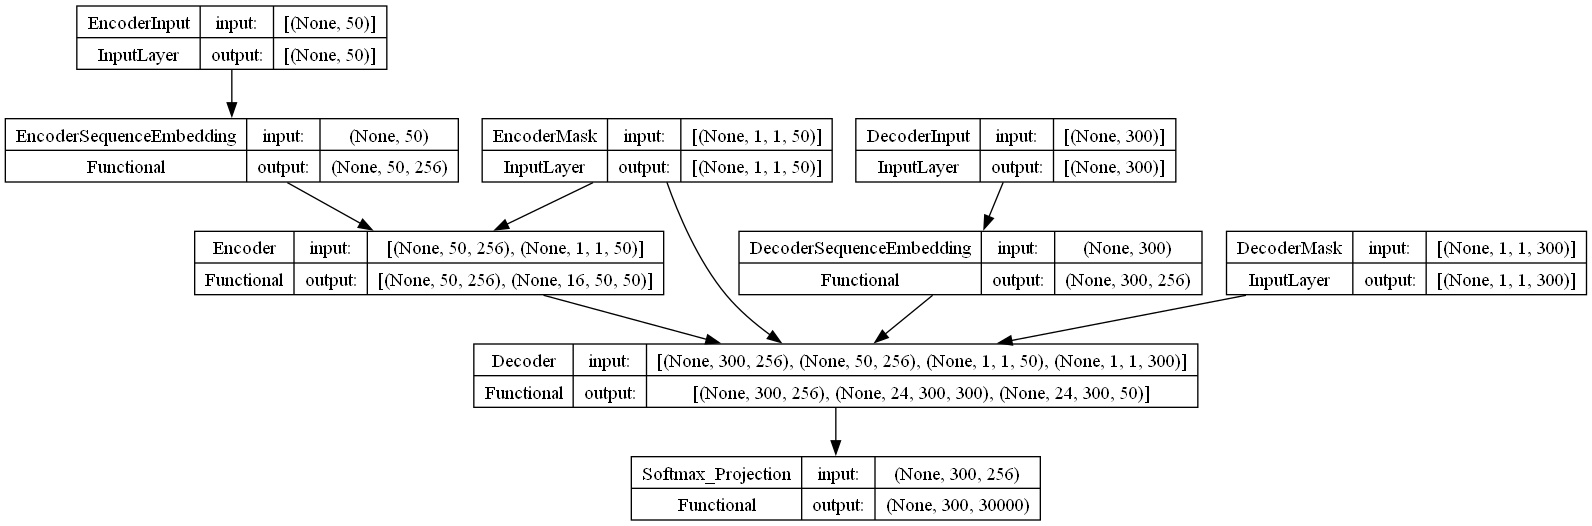

In [16]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [17]:
Train_data_loader=data_loader(X_train,Y_train,50,300,0)
callbacks=myCallback(model,X_test,Y_test,tokenizer)

In [19]:
history=model.fit(Train_data_loader,epochs=90000000000,initial_epoch=0,steps_per_epoch=500,callbacks=[callbacks])

Epoch 1/90000000000
500/500 [==============================] - 249s 448ms/step - loss: 2.2886 - accuracy: 0.6900
Epoch 2/90000000000
500/500 [==============================] - 243s 485ms/step - loss: 2.3242 - accuracy: 0.6877
Epoch 3/90000000000
500/500 [==============================] - 241s 483ms/step - loss: 2.3456 - accuracy: 0.6853
Epoch 4/90000000000
500/500 [==============================] - 253s 506ms/step - loss: 2.3069 - accuracy: 0.6837
Epoch 5/90000000000
500/500 [==============================] - 261s 521ms/step - loss: 2.1746 - accuracy: 0.7076
Epoch 6/90000000000
500/500 [==============================] - 241s 483ms/step - loss: 2.3717 - accuracy: 0.6806
Epoch 7/90000000000
  1/500 [..............................] - ETA: 4:37 - loss: 0.5511 - accuracy: 0.9053

ResourceExhaustedError: Graph execution error:

Detected at node 'TrainingTransformer/Softmax_Projection/Projection_Softmax/BiasAdd' defined at (most recent call last):
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Sagar\AppData\Local\Temp\ipykernel_20824\943796326.py", line 1, in <module>
      history=model.fit(Train_data_loader,epochs=90000000000,initial_epoch=0,steps_per_epoch=500,callbacks=[callbacks])
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\keras\layers\core\dense.py", line 252, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'TrainingTransformer/Softmax_Projection/Projection_Softmax/BiasAdd'
OOM when allocating tensor with shape[10,300,30000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node TrainingTransformer/Softmax_Projection/Projection_Softmax/BiasAdd}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1284491]

In [ ]:
model.save(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Poetry\results\model_0.h5")

In [18]:
model=tf.keras.models.load_model(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/GAN Poetry/results/models/model_{9}.h5")